In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
import numpy as np

# For dataset download & unzip
if not os.path.exists("cats_and_dogs_filtered"):
    os.system("curl -O https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")
    os.system("unzip -q cats_and_dogs_filtered.zip")

train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

# CNN model definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
data = []
# Dataset class
class CatsAndDogsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for label, class_name in enumerate(sorted(os.listdir(directory))):
            class_dir = os.path.join(directory, class_name)
            for fname in os.listdir(class_dir):
                if fname.endswith(".jpg"):
                    self.image_paths.append(os.path.join(class_dir, fname))
                    self.labels.append(label)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# Image transformations (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load datasets & dataloaders
train_dataset = CatsAndDogsDataset(train_dir, transform=transform)
val_dataset = CatsAndDogsDataset(validation_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss, optimizer
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    # Training
    model.train()
    train_losses = []
    train_preds = []
    train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = (outputs > 0.5).float()
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    train_prec = precision_score(train_labels, train_preds)
    train_rec = recall_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)
    train_auc = roc_auc_score(train_labels, train_preds)
    train_loss = np.mean(train_losses)

    # Validation
    model.eval()
    val_losses = []
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            preds = (outputs > 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    val_prec = precision_score(val_labels, val_preds)
    val_rec = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_auc = roc_auc_score(val_labels, val_preds)
    val_loss = np.mean(val_losses)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
    # print(f"Classification Report:\n{classification_report(val_labels, val_preds, target_names=['Cat','Dog'])}")
    data.append(classification_report(val_labels, val_preds, target_names=['Cat','Dog']))
# Save the trained model
torch.save(model.state_dict(), 'cats_dogs_cnn_gpu.pth')
print("Model saved to cats_dogs_cnn_gpu.pth")

# Predict function
def predict(image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img).item()
    return "Dog" if output > 0.5 else "Cat"

# Example usage:
# print(predict("path_to_some_image.jpg"))


Using device: cuda
Epoch 1/20
Train Loss: 0.7360, Acc: 54.10%, Prec: 0.5352, Rec: 0.6240, F1: 0.5762, AUC: 0.5410
Val   Loss: 0.6609, Acc: 59.50%, Prec: 0.6462, Rec: 0.4200, F1: 0.5091, AUC: 0.5950
Epoch 2/20
Train Loss: 0.6719, Acc: 57.15%, Prec: 0.6357, Rec: 0.3350, F1: 0.4388, AUC: 0.5715
Val   Loss: 0.6889, Acc: 55.30%, Prec: 0.5351, Rec: 0.8080, F1: 0.6438, AUC: 0.5530
Epoch 3/20
Train Loss: 0.6569, Acc: 59.65%, Prec: 0.6187, Rec: 0.5030, F1: 0.5549, AUC: 0.5965
Val   Loss: 0.6578, Acc: 60.50%, Prec: 0.6144, Rec: 0.5640, F1: 0.5881, AUC: 0.6050
Epoch 4/20
Train Loss: 0.6467, Acc: 60.45%, Prec: 0.6462, Rec: 0.4620, F1: 0.5388, AUC: 0.6045
Val   Loss: 0.6653, Acc: 59.20%, Prec: 0.7840, Rec: 0.2540, F1: 0.3837, AUC: 0.5920
Epoch 5/20
Train Loss: 0.6164, Acc: 65.55%, Prec: 0.7012, Rec: 0.5420, F1: 0.6114, AUC: 0.6555
Val   Loss: 0.6451, Acc: 65.90%, Prec: 0.7540, Rec: 0.4720, F1: 0.5806, AUC: 0.6590
Epoch 6/20
Train Loss: 0.5753, Acc: 70.40%, Prec: 0.7121, Rec: 0.6850, F1: 0.6983, AUC

In [12]:
print(predict("cat.jpg"))

Cat


In [17]:
18609/32

581.53125

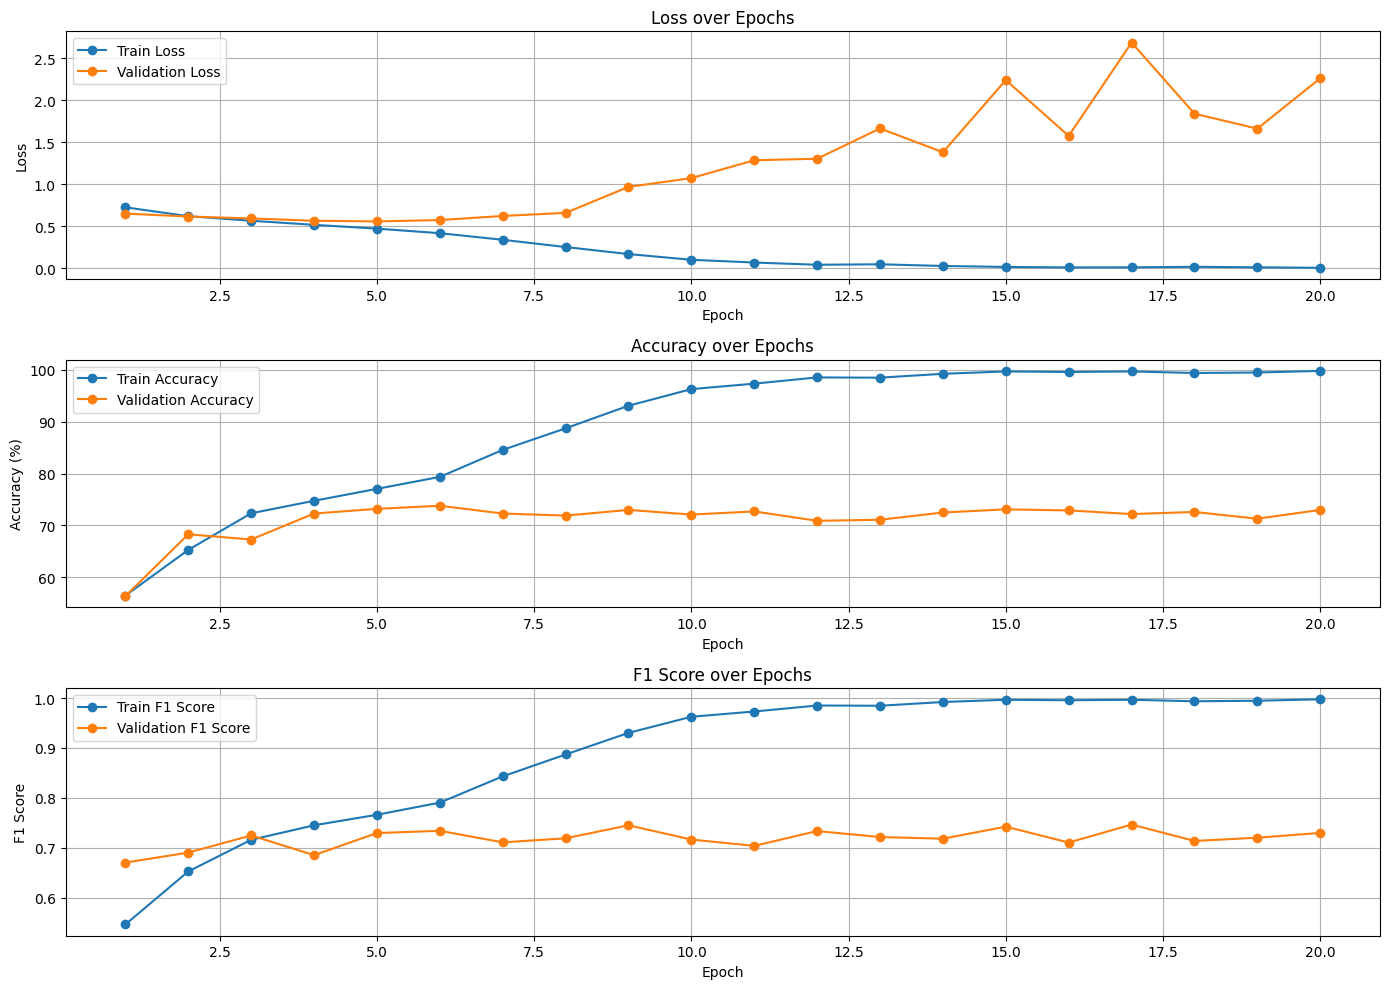

In [13]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 21)

train_loss = [0.7268, 0.6213, 0.5673, 0.5183, 0.4734, 0.4191, 0.3406, 0.2546, 0.1708, 0.1029, 0.0702, 0.0437, 0.0495, 0.0293, 0.0178, 0.0121, 0.0129, 0.0194, 0.0132, 0.0076]
val_loss = [0.6519, 0.6173, 0.5946, 0.5672, 0.5588, 0.5754, 0.6241, 0.6608, 0.9697, 1.0742, 1.2864, 1.3048, 1.6648, 1.3818, 2.2397, 1.5762, 2.6858, 1.8405, 1.6625, 2.2613]

train_acc = [56.50, 65.30, 72.35, 74.75, 77.05, 79.35, 84.55, 88.70, 93.05, 96.25, 97.30, 98.50, 98.45, 99.20, 99.65, 99.55, 99.65, 99.35, 99.45, 99.75]
val_acc = [56.40, 68.30, 67.30, 72.30, 73.20, 73.80, 72.30, 71.90, 73.00, 72.10, 72.70, 70.90, 71.10, 72.50, 73.10, 72.90, 72.20, 72.60, 71.30, 73.00]

train_f1 = [0.5469, 0.6530, 0.7163, 0.7453, 0.7664, 0.7907, 0.8432, 0.8870, 0.9302, 0.9625, 0.9730, 0.9850, 0.9845, 0.9920, 0.9965, 0.9955, 0.9965, 0.9935, 0.9945, 0.9975]
val_f1 = [0.6707, 0.6907, 0.7250, 0.6856, 0.7298, 0.7343, 0.7112, 0.7193, 0.7453, 0.7168, 0.7042, 0.7338, 0.7218, 0.7185, 0.7426, 0.7108, 0.7468, 0.7140, 0.7205, 0.7300]

plt.figure(figsize=(14, 10))

plt.subplot(3,1,1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(epochs, train_f1, label='Train F1 Score', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', marker='o')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
